In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tqdm import tqdm

from utils import *

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)
print(info)

INFO:absl:Load dataset info from C:\Users\AdmPDI\tensorflow_datasets\oxford_iiit_pet\4.0.0
INFO:absl:Creating a tf.data.Dataset reading 4 files located in folders: C:\Users\AdmPDI\tensorflow_datasets\oxford_iiit_pet\4.0.0.
INFO:absl:Creating a tf.data.Dataset reading 4 files located in folders: C:\Users\AdmPDI\tensorflow_datasets\oxford_iiit_pet\4.0.0.
INFO:absl:Constructing tf.data.Dataset oxford_iiit_pet for split None, from C:\Users\AdmPDI\tensorflow_datasets\oxford_iiit_pet\4.0.0


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\AdmPDI\\tensorflow_datasets\\oxford_iiit_pet\\4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'l

In [6]:
INPUT_SIZE = (128, 128)

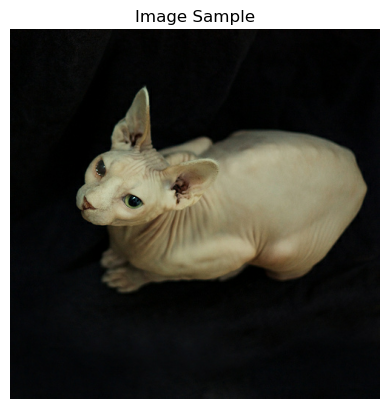

In [8]:
sample = next(iter(dataset["train"]))

imshow(image=sample["image"].numpy().astype("uint8"), title="Image Sample")

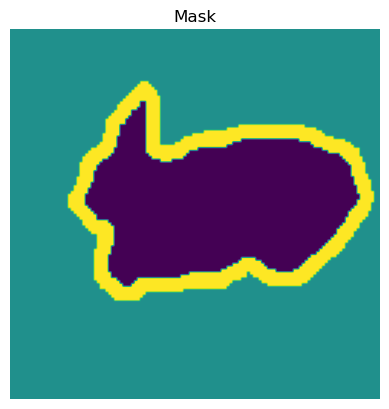

In [9]:
imshow(image=tf.keras.preprocessing.image.smart_resize(sample["segmentation_mask"], size=INPUT_SIZE, interpolation="nearest").numpy().astype("uint8"), title="Mask")

In [16]:
x_train, y_train = prepare_dataset(dataset=dataset["train"], target_size=INPUT_SIZE)
x_test, y_test = prepare_dataset(dataset=dataset["test"], target_size=INPUT_SIZE)

0it [00:00, ?it/s]INFO:utils:Original image shape: (500, 500, 3)
INFO:utils:(500, 500, 1)
INFO:utils:Original image shape: (313, 500, 3)
INFO:utils:(313, 500, 1)
INFO:utils:Original image shape: (500, 333, 3)
INFO:utils:(500, 333, 1)
INFO:utils:Original image shape: (375, 500, 3)
INFO:utils:(375, 500, 1)
INFO:utils:Original image shape: (500, 333, 3)
INFO:utils:(500, 333, 1)
INFO:utils:Original image shape: (219, 300, 3)
INFO:utils:(219, 300, 1)
INFO:utils:Original image shape: (400, 500, 3)
INFO:utils:(400, 500, 1)
INFO:utils:Original image shape: (500, 333, 3)
INFO:utils:(500, 333, 1)
INFO:utils:Original image shape: (191, 300, 3)
INFO:utils:(191, 300, 1)
INFO:utils:Original image shape: (225, 300, 3)
INFO:utils:(225, 300, 1)
INFO:utils:Original image shape: (375, 500, 3)
INFO:utils:(375, 500, 1)
INFO:utils:Original image shape: (333, 500, 3)
INFO:utils:(333, 500, 1)
12it [00:00, 119.45it/s]INFO:utils:Original image shape: (375, 500, 3)
INFO:utils:(375, 500, 1)
INFO:utils:Original im

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Input
from models import encoder, decoder

model = Sequential(
    [
        Input(shape = INPUT_SIZE + (3,)),
        encoder,
        decoder,
        Conv2D(3, 1, padding="same", activation = "softmax")
    ],
    name = "encoder_decoder"
)

model.summary()

Model: "encoder_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 16, 16, 256)    │     1,145,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 128, 128, 64)   │     1,733,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 3)    │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,879,107 (10.98 MB)

 Trainable params: 2,879,107 (10.98 MB)

 Non-trainable params: 0 (0.00 B)

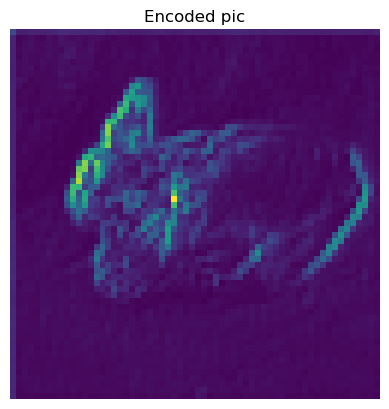

In [51]:
x = sample["image"]
x_encoded = encoder(tf.expand_dims(x, axis=0))
imshow(x_encoded[0].numpy().mean(axis=-1), title="Encoded pic")

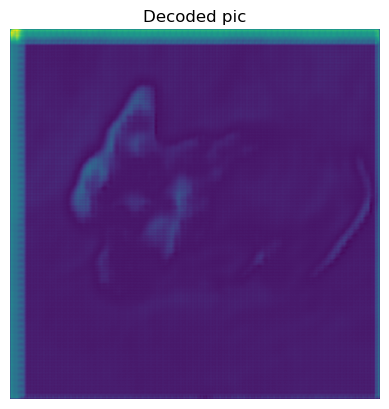

In [50]:
x_decoded = decoder(x_encoded)
imshow(x_decoded[0].numpy().mean(axis=-1), title="Decoded pic")

In [41]:
from tensorflow.keras import optimizers

LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 16
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

In [42]:
model.compile(optimizer = optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [43]:
history = model.fit(x_train,
                    y_train,
                    batch_size = BATCH_SIZE,
                    validation_split = 0.15,
                    epochs = EPOCHS)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.5231 - loss: 0.9901 - val_accuracy: 0.6271 - val_loss: 0.9083
Epoch 2/20
 24/196 ━━━━━━━━━━━━━━━━━━━━ 7:05 2s/step - accuracy: 0.6385 - loss: 0.8522

KeyboardInterrupt: 